<a href="https://colab.research.google.com/github/Gdkmak/analytics/blob/master/EDA_Data_Science_Jobs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Job - Explotary Data Analysis
In this gist we will take a deep look on Data Science Jobs dataset, and try to explore some hidden detailes in mutiple industries and for different job describtions. The dataset was created by [picklesueat](https://github.com/picklesueat/data_jobs_data) and contains more than 3900 job listing for data scientist positions scraped fron glassdoor, with features such as:

1. Salary Estimate
2. Location
3. Company Rating
4. Company Size
5. Job Description and more.

In [ ]:
# get the dataset from github first
!wget https://raw.githubusercontent.com/picklesueat/data_jobs_data/master/DataScientist.csv

In [ ]:
!pip install -U yellowbrick # make ensure the latest version of yellowbrick is installed

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from tqdm import tqdm
from folium import plugins
import folium

In [ ]:
df = pd.read_csv('DataScientist.csv')
df.head()

Unnamed: 0  index  ...               Competitors Easy Apply
0           0      0  ...                        -1         -1
1           1      1  ...                        -1         -1
2           2      2  ...                        -1       True
3           3      3  ...      Zocdoc, Healthgrades         -1
4           4      4  ...  BBDO, Grey Group, Droga5         -1

[5 rows x 17 columns]

## Data Cleaning

There are a few things I would like to clean up with this dataset to lend itself to analysis:

1. Remove unwanted columns.
2. Split Salary Estimate into lower and higher bound.
3. Split Size also into lower and higher bound.
4. Split Revenue into into lower and higher bound.
5. Clean Company Name.
6. Replace -1 into np.nan value. 

First and foremost I am going to git rid of the unnecessary columns like the first one (unnamed: 0). This can be acheived in to ways; the first one is an easy one, which uses drop. a) `new_df = df.drop(columns = 'Unnamed: 0')`
second by using iloc to take all the columns except the one we don't want
b) `new_df = df.iloc[:,1::] `

In [ ]:
new_df = df
new_df = df.drop(columns = 'Unnamed: 0')

A helper function to split the three abovementioned columns into lower and higher boundary. Plus I will standardised the unites in each columns. For example, Rvenue column has MILLION and BILLION.

In [ ]:
def low_high_boundry(value, fsplit='-', ssplit='('):
  """
  Input:
        value: (string) value in the column that containes both the lower and higher bound. 
        fsplit: the first split to get the lower bound.
        ssplit: the second spit to get the higer bound.
  Output: 
        low: (int) the extracted lower value from the text.
        high: (int) the extracted higher value from the text.
  """
  to_billion_lower = 1 
  to_billion_higher = 1

  if len(value.split(fsplit)) > 1:              # make sure the text has higher and lower bound
    low = value.split(fsplit)[0]
    low = low.replace('$', '').replace('K', '').strip()
                                      
    if 'million' in low:                        # the text in Revenue column has million and billion values, I will convert billion value to million 
      to_billion_higher = 1000
    else: 
      if 'billion' in value.split(fsplit)[1]: 
        to_billion_lower = 1000
        to_billion_higher = 1000
        
    low = low.replace('million', '').strip()    # to delete 'million' word from the text
    low = int(low)
    low = low * to_billion_lower
    high = value.split(fsplit)[1].strip().split(ssplit)[0]
    high = high.replace('$', '').replace('K','').strip()
    
    if value.split(fsplit)[1].strip().split(ssplit)[1] == 'billion':
      high = high.replace('billion', '').strip() # to delete 'million' word from the text 
      high = int(high) * to_billion_higher
    else:
      high = high.replace('million', '')
      high = int(high) * to_billion_higher
  else:                                          # in case there is no mention to the higher bound
    low = value.split(ssplit)[0]
    if low in ('-1', 'Unknown'): 
      low = np.nan
      high = np.nan
    elif low == 'Less':
      low = np.nan
      high = 1
    else:
      low = int(low.split('+')[0].strip('$')) * 1000
      high = np.nan 
  return low, high

Cleaning Salary Estimate and create lower and higher bounds

In [ ]:
# When you look at the data in Salary Estimate variable you notice that there are two types of salaries, 
# the first one is PER HOUR or ANNUALLY.

HOURS_PER_WEEK = 40 
DAYS_PER_YEAR = 52

for i, salary in enumerate(new_df['Salary Estimate'].values):
   if 'Per' in salary:
     low, high = low_high_boundry(salary, ssplit='Per')
     low  = low * HOURS_PER_WEEK * DAYS_PER_YEAR / 1000
     high = high * HOURS_PER_WEEK * DAYS_PER_YEAR / 1000
     new_df.loc[i,'low_salary'] = low
     new_df.loc[i,'high_salary'] = high
   else:  
      low, high = low_high_boundry(salary)
      new_df.loc[i,'low_salary'] = low
      new_df.loc[i,'high_salary'] = high

Create a company size lower and higher bounds 

In [ ]:
for i, emp_size in enumerate(new_df['Size'].values):
  low, high = low_high_boundry(emp_size,fsplit='to', ssplit='employees')
  new_df.loc[i, 'low_company_size']= low
  new_df.loc[i, 'high_company_size']= high

Create Revenue lower and higher bounds

In [ ]:
for i, revenue in enumerate(new_df['Revenue'].values):
  low, high = low_high_boundry(revenue, fsplit='to', ssplit=' ')
  new_df.loc[i, 'low_revenue']= low
  new_df.loc[i, 'high_revenue']= high

Clean the company name text

In [ ]:
for i, cmp_name in enumerate(new_df['Company Name'].values): 
  name = new_df.loc[i,'Company Name']
  new_df.loc[i, 'Company Name'] = name.split('\n')[0].strip()

Clean location names 

In [ ]:
for i in range(new_df.shape[0]):
  location = new_df.loc[i,'Location']
  if str(location) != -1:
      if location == 'Monaco, CA':    # It confuses with Monaco, France
          location = 'North Redondo, CA'
      if 'Northbrook, IL' == location:
          location = location.replace('Northbrook, IL', 'Deerfield, Illinois')
      if 'CA' in location:
          location = location.replace("CA", "California")
      if 'IL' in location:
          location = location.replace("IL", "Illinois")
      if 'PA' in location:
          location = location.replace("PA", "Pennsylvania")
  new_df.loc[i,'Location'] = location

Drop the unneeded variables Salary, Revenue, Company Size

In [ ]:
new_df = new_df.drop(columns='Revenue')
new_df = new_df.drop(columns='Salary Estimate')
new_df = new_df.drop(columns='Size')
# replace -1(s) with np.nan
new_df = new_df.replace('-1', np.nan)
new_df.head()

index                          Job Title  ... low_revenue  high_revenue
0      0              Senior Data Scientist  ...         NaN           NaN
1      1  Data Scientist, Product Analytics  ...         NaN           NaN
2      2               Data Science Manager  ...         NaN           NaN
3      3                       Data Analyst  ...         NaN           NaN
4      4             Director, Data Science  ...         NaN           NaN

[5 rows x 19 columns]

Get the mean of slaraies, revenue and size lower and higher bounds


In [ ]:
def mean_columns(df ,*column_names):
  """
  Input: 
        df: dataframe 
        *column_names: multiple entry to column names from the datafram
  Output: 
        pd_series: pandas series that has the mean of the columns mentioned in the parameter 
  """ 
  col_values = df.loc[:,[col for col in column_names]]
  pd_series = col_values.mean(axis=1)
  return pd_series

In [ ]:
new_df['Salary_boundaries_mean'] = mean_columns(new_df, 'low_salary','high_salary')
new_df['Revenue_boundaries_mean'] = mean_columns(new_df, 'low_revenue','high_revenue')
new_df['Size_boundaries_mean'] = mean_columns(new_df, 'low_company_size','high_company_size')

## Exploratory Data Analysis 

In [ ]:
# lets have a look at the frequency of posts in each industry 
industry_freq = new_df['Industry'].value_counts()
industry_freq

IT Services                           472
Staffing & Outsourcing                313
Biotech & Pharmaceuticals             293
Computer Hardware & Software          264
Internet                              238
                                     ... 
Museums, Zoos & Amusement Parks         1
Metals Brokers                          1
Self-Storage Services                   1
Health Fundraising Organizations        1
Home Furniture & Housewares Stores      1
Name: Industry, Length: 95, dtype: int64

It looks like the IT service compamies have the highest numbers of posted roles then outsourcing industry comes next.


In [ ]:
# There are some industries that have only a few posts/rows in the dataset, I will drop industries that have less than 20 posts
CUTS = 20 
to_drop = []
for i in range(new_df.shape[0]):
  industry = str(new_df.loc[i,'Industry'])
  if  industry != 'nan':
    if industry_freq[industry] < CUTS:
      to_drop.append(i)

trimed_df = new_df.drop(to_drop).reset_index()

In [ ]:
def boxenplot_chart(new_df, colx, coly, order_by, chart_name):
  """
  Input:
        new_df: pandas dataframe
        colx: X data for the chart
        coly: Y data for the chart
        order_by: pandas series that will sort the elements in the chart  
        chart_name: (string) chart title 
  Output:
        plt: matplolib object
  """
  sns.set(style="darkgrid", color_codes=True)
  g = sns.catplot(x=colx, y=coly, kind="boxen", data=new_df, order=order_by.iloc[:25].index)
  g.set(xlim=(0, 250))
  g.fig.set_size_inches(30, 10)
  g.ax.set_xticks([50,75,100,125,150,175,200,225,250,300], minor=True)
  plt.title(chart_name)
  return plt

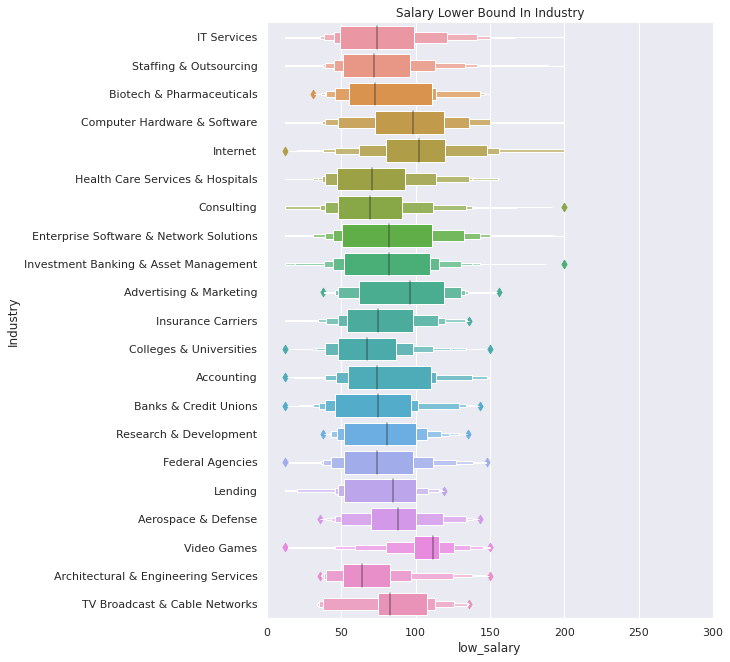

In [ ]:
plt = boxenplot_chart(trimed_df, 
                      'low_salary', 
                      'Industry',
                      trimed_df['Industry'].value_counts(),
                      chart_name='Salary Lower Bound In Industry')
plt.show()

Looks like if you are applying as a junior in video games industries, the low salary you'd get is better than other industries in the market. 

Lets sort the above results by their median. 

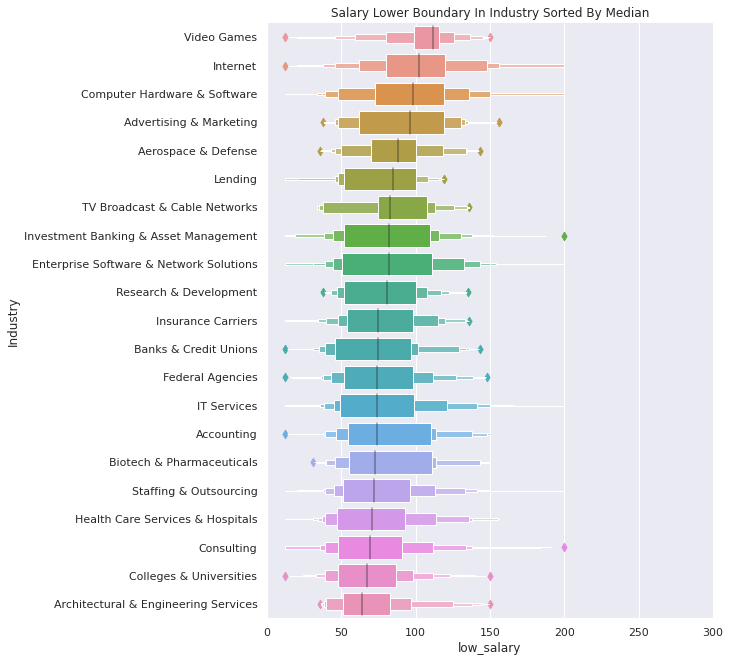

In [ ]:
sr_median = trimed_df.groupby('Industry')['low_salary'].median().sort_values(ascending=False)

plt = boxenplot_chart(trimed_df, 
                      'low_salary', 
                      'Industry', 
                      order_by=sr_median,
                      chart_name='Salary Lower Boundary In Industry Sorted By Median')
plt.show()

Now lets repeate the same thing but for the high bound salary.

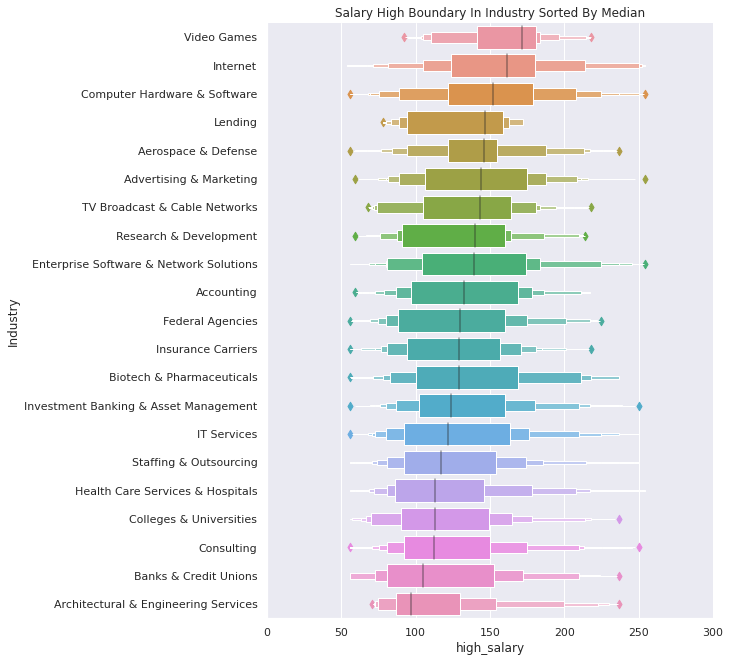

In [ ]:
sr_median = trimed_df.groupby('Industry')['high_salary'].median().sort_values(ascending=False)
plt = boxenplot_chart(trimed_df, 
                      'high_salary', 
                      'Industry', 
                      order_by=sr_median,
                      chart_name='Salary High Boundary In Industry Sorted By Median')
plt.show()

Again the same results for the higher bound, the video games is still the highest in terms of salaries.

## Location vs salary

First we need to use the longitude and latitude AND for that we need to parse them and get the longitude and latitude according to the names in the data frame. 

In [ ]:
# Instantiate Nominatim object 
geolocator = Nominatim(user_agent='ghaith')
set_locations = trimed_df['Location'].unique()
location_dict = {} 
 
# get the latitude and longitude, store them in a dictionary
for location in tqdm(set_locations.tolist()):
  if str(location) != 'nan': 
    geolcator = geolocator.geocode(location)
    if geolcator != None:
      location_dict[location] = (geolcator.longitude, geolcator.latitude)

100%|██████████| 171/171 [02:28<00:00,  1.15it/s]


In [ ]:
# Create longitude and latitude columns
for i in range(trimed_df.shape[0]):
  location = trimed_df.loc[i, 'Location'] 
  if str(location) != 'nan': 
    trimed_df.loc[i, 'longitude'] = location_dict.get(location, (np.nan,np.nan))[0]
    trimed_df.loc[i, 'latitude'] =  location_dict.get(location, (np.nan,np.nan))[1]
  else:
    trimed_df.loc[i, 'longitude'] = np.nan
    trimed_df.loc[i, 'latitude'] =  np.nan
  

In [ ]:
temp = trimed_df.copy()

temp['longitude'] = trimed_df['longitude'].astype(float) # make sure the coordinates are float and no na(s)
temp['latitude'] = trimed_df['latitude'].astype(float)
temp = temp.dropna(axis = 0, subset= ['latitude','longitude']).reset_index(drop=True)
heat_df = temp[['latitude','longitude']]

heat_map = folium.Map([41.8781, -96.6298], zoom_start = 5)

# List comprehension to make out list of lists, otherwise it will go in recursion without halting
heat_data = [[row['latitude'],row['longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
plugins.HeatMap(heat_data, radius=15).add_to(heat_map)

# Display the map
heat_map

We can see that data science jobs are clustered around a few American cities mainly Los Angeles, San Francisco, New York and London. I think it'd be more informative if we apply KMeans and cluster the different jobs and then see where the cluster centers are as well as how many jobs are associated with each cluster. 

There is a nice package called `yellowbrick` that has a `KElbowVisualizer` class that implements the “elbow” method to help select the optimal number of clusters by fitting the model with a range of values for K. Nice isn't?! 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


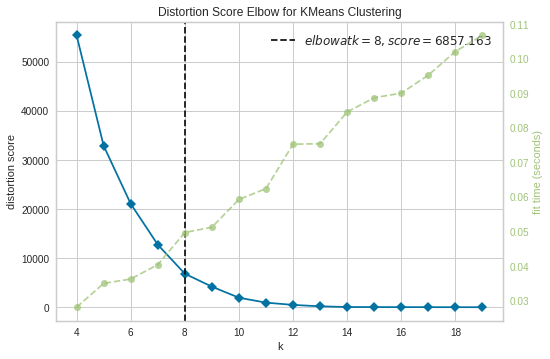

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

X_kmeans = heat_df[['latitude', 'longitude']]

visualizer = KElbowVisualizer(KMeans(), k=(4,20))
visualizer.fit(X_kmeans)  # Fit the data to the visualizer
visualizer.show() 

According to the Distrotion Score Elbow the optimal number for clustering is 8, just for sake of presenting I will choose k as 14.  

In [ ]:
COLORS = ['#E6B0AA', '#EC7063', '#AF7AC5', '#7D3C98', '#5499C7', '#AED6F1 ', '#A3E4D7', 
          '#16A085', '#229954', '#58D68D', '#F7DC6F', '#F5B041', '#AF601A', '#6E2C00', '#7F8C8D' ]

CLUSTER_NAME = [ 'Dallas, TX',  'San Francisco Bay, CA','Columbus, OH', 'San Diego, CA',  'Philadelphia, PA','London, UK' ,'Chicago, IL', 
               'Jacksonville, FL', 'Phoenix, AZ','Austin, TX', 'Houston, TX', 'Los Angeles, CA',
               'New York, NY', 'San Antonio, TX']

kmeans = KMeans(n_clusters=14, random_state=0).fit(X_kmeans)
kmeans.cluster_centers_

# create a new column that has cluster where the point belongs to
for i in range(trimed_df.shape[0]-1):
    cluster = kmeans.labels_[i]
    trimed_df.loc[i, 'cluster_area'] = CLUSTER_NAME[cluster]

clusterd_map = folium.Map([41.8781, -96.6298], zoom_start=5)

for i in range(kmeans.cluster_centers_.shape[0]):
    num = sum(kmeans.labels_==i)
    folium.CircleMarker([kmeans.cluster_centers_[i,0], 
                        kmeans.cluster_centers_[i,1]],
                        radius=30,
                        popup=f'{str(num)} found in {CLUSTER_NAME[i]} cluster',
                        fill_color=COLORS[i],
                        fill_opacity=0.7).add_to(clusterd_map)


for i in range(temp.shape[0]):
    folium.CircleMarker([temp.loc[i,'latitude'], 
                        temp.loc[i,'longitude']],
                        radius=15,
                        popup=temp.loc[i,'Location'] ,
                        fill_color="#b6fc03", 
                        fill_opacity=.7).add_to(clusterd_map)
clusterd_map

As you can see each city belongs to a cluster that is positioned in the middle. Here are the cluster centers ranked with the number of jobs:

1. 412 found in Dallas, TX cluster
2. 343 found in San Francisco Bay, CA cluster
3. 311 found in San Diego, CA cluster
4. 310 found in Philadelphia, PA cluster
5. 308 found in Austin, TX cluster
6. 303 found in Chicago, IL cluster
7. 302 found in Los Angeles, CA cluster
8. 268 found in New York, NY cluster
9. 258 found in Phoenix, AZ cluster
10. 199 found in Houston, TX cluster
11. 177 found in San Antonio, TX cluster
12. 159 found in Columbus, OH cluster
13. 62 found in Jacksonville, FL cluster
14. 4 found in London, UK cluster


Let's see the salaries according to the clusters:

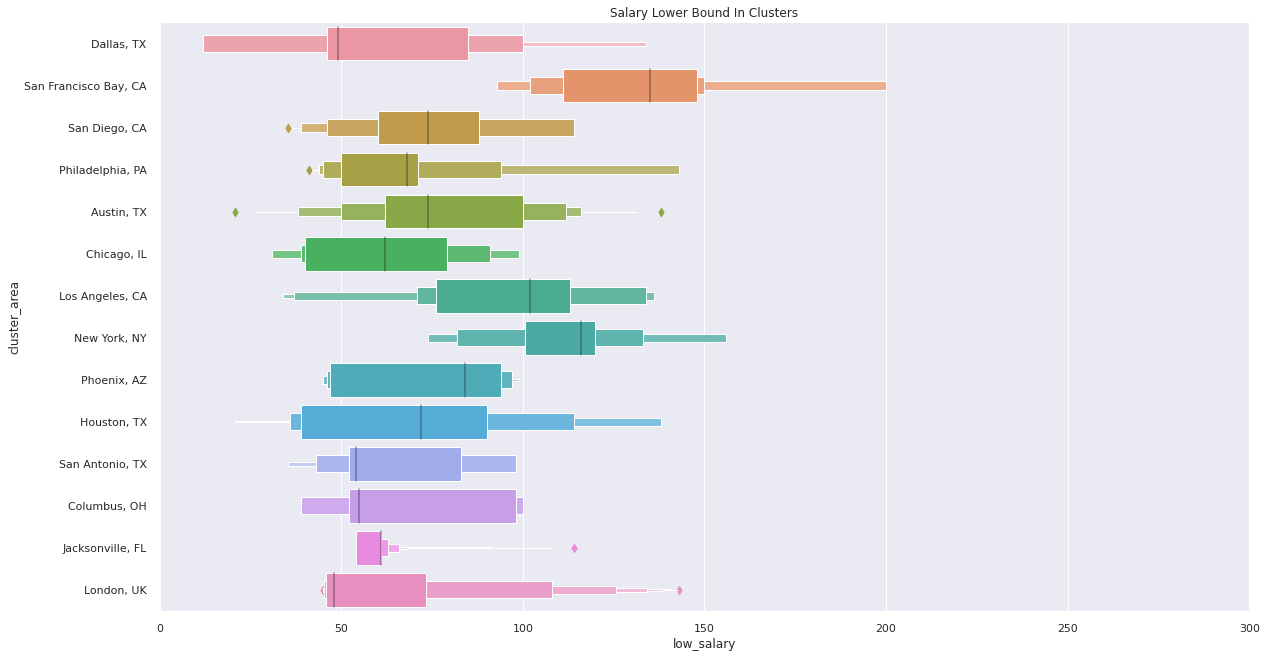

In [ ]:
plt = boxenplot_chart(trimed_df, 
                      'low_salary', 
                      'cluster_area',
                      trimed_df['cluster_area'].value_counts(),
                      chart_name='Salary Lower Bound In Clusters')
plt.show()

Just I am gonna sort the chart above according to the salary median

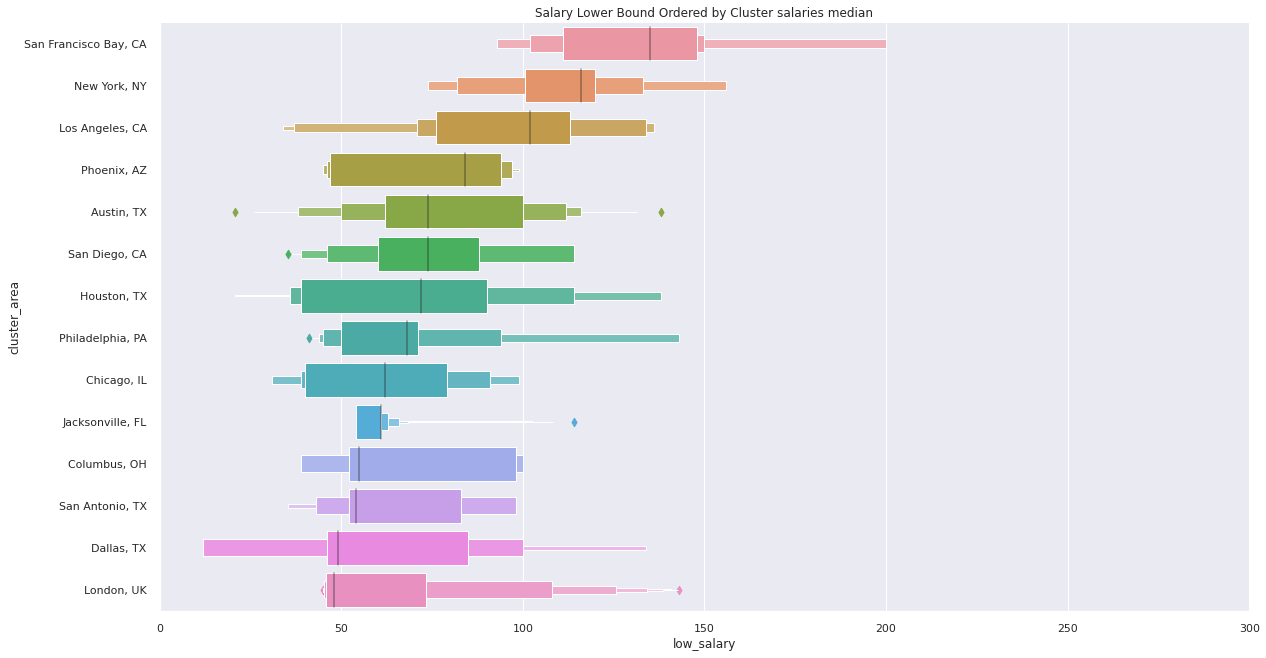

In [ ]:
plt = boxenplot_chart(trimed_df, 
                      'low_salary', 
                      'cluster_area',
                      trimed_df.groupby('cluster_area').median().sort_values(by='low_salary', ascending=False) ,
                      chart_name='Salary Lower Bound Ordered by Cluster salaries median')
plt.show()

San Francisco and New York always come first, let's check the higher bound as well.  

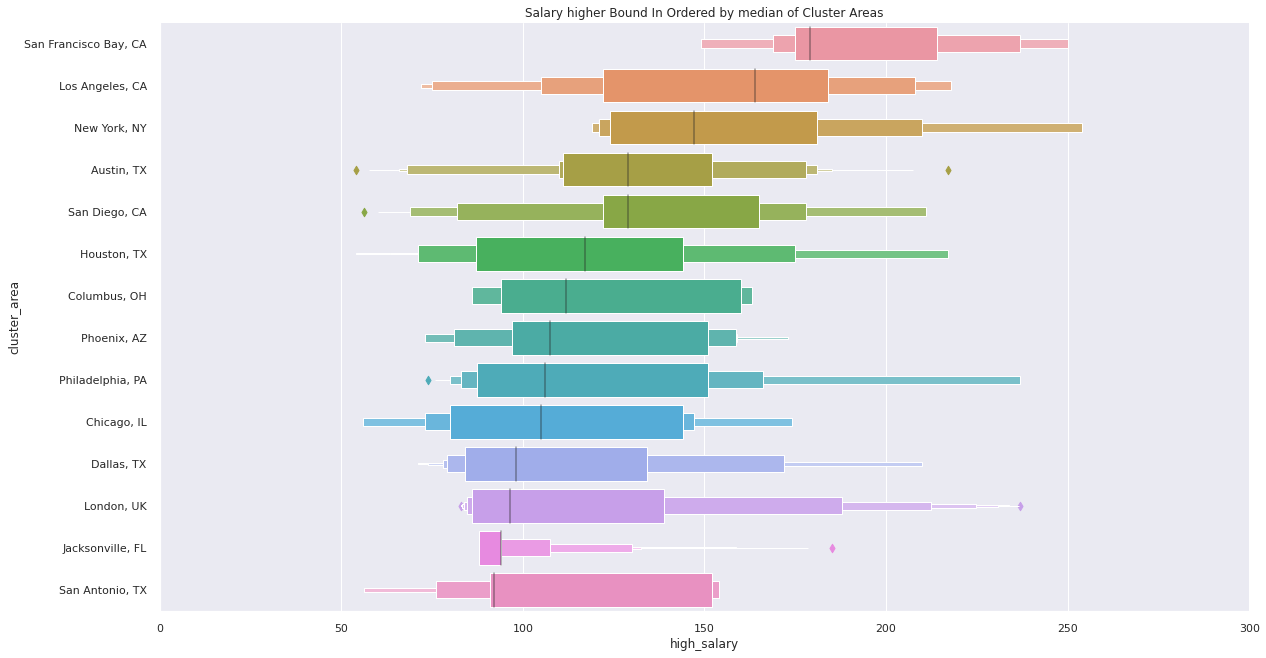

In [ ]:
plt = boxenplot_chart(trimed_df, 
                      'high_salary', 
                      'cluster_area',
                      trimed_df.groupby('cluster_area').median().sort_values(by='high_salary', ascending=False) ,
                      chart_name='Salary higher Bound In Ordered by median of Cluster Areas')
plt.show()

This time Los Angeles comes second yet San Francisco is still first. Obviously San Francisco, New York and Los Angelese where the good salries are, but still they don't have the highest mumber of posted jobs Dallas has it. A question here can be raised if the cost of living took into consideration, how the data would look like?


To answer this question, I will compare the cost of living among the clusters making Dallas, TX as a baseline for comprison. I took data from [expatistan](https://www.expatistan.com/cost-of-living) 


In [ ]:
# Cost of living rate condiering Dallas as a baseline (1)
CoLo = [1. , 1-.58, 1.13, 1-.19, 1-.15, 1-.45, 1-.27, 1.10, 1., 1-.06, 1.07, 1-.30, 1-.62, 1.10]

for i in range(trimed_df.shape[0]): 
  clus = trimed_df.loc[i, 'cluster_area']
  if str(clus) == 'nan':
    continue
  idx = CLUSTER_NAME.index(clus)
  trimed_df.loc[i, 'low_salary_adjusted']=CoLo[idx] * trimed_df.loc[i, 'low_salary'] 
  trimed_df.loc[i, 'high_salary_adjusted']=CoLo[idx] * trimed_df.loc[i, 'high_salary']

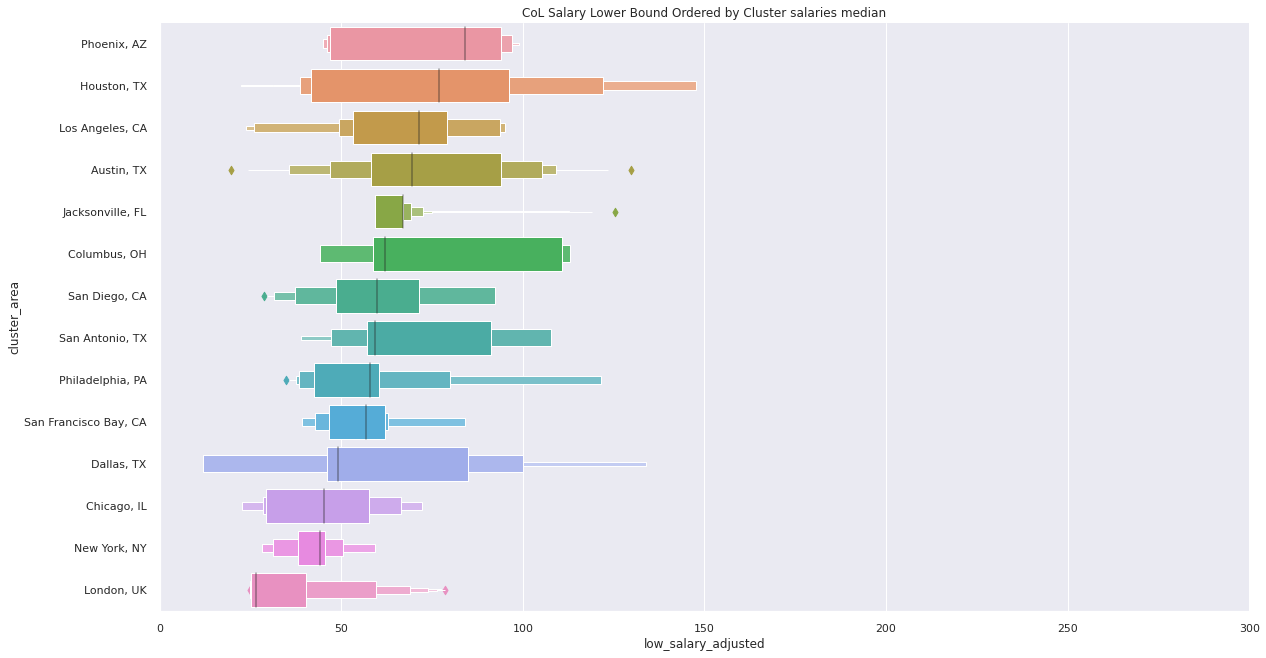

In [ ]:
plt = boxenplot_chart(trimed_df, 
                    'low_salary_adjusted', 
                    'cluster_area',
                    trimed_df.groupby('cluster_area').median().sort_values(by='low_salary_adjusted', ascending=False) ,
                    chart_name='CoL Salary Lower Bound Ordered by Cluster salaries median')
plt.show()

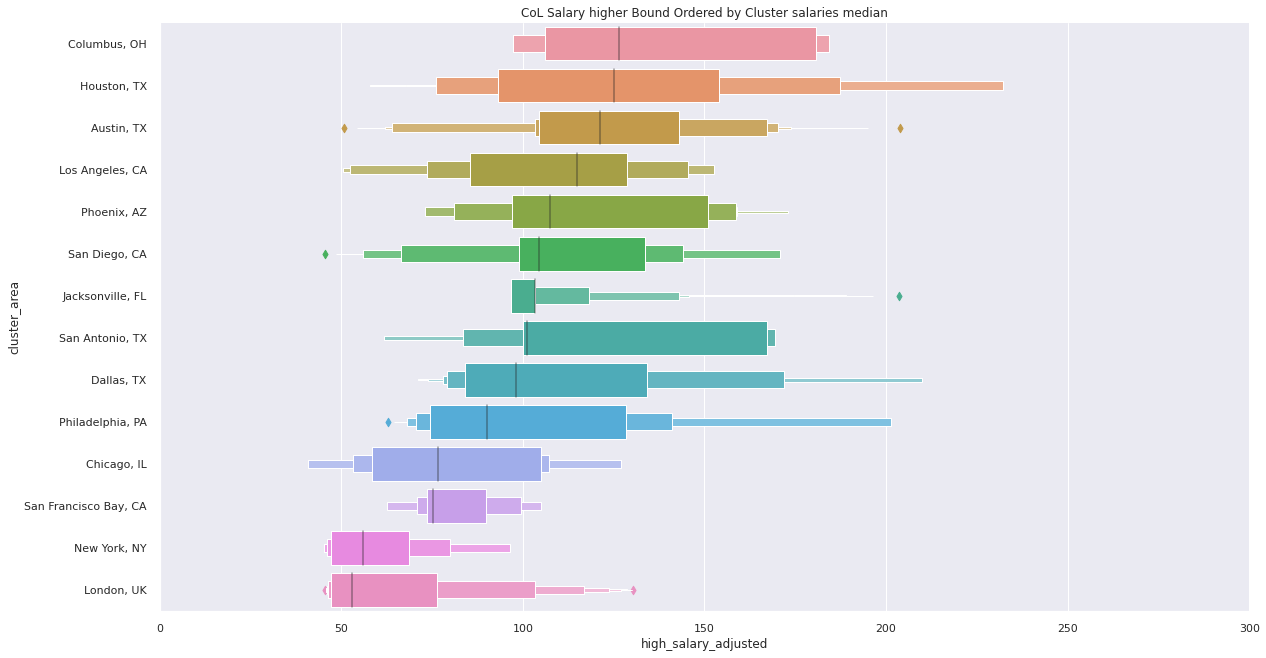

In [ ]:
plt = boxenplot_chart(trimed_df, 
                    'high_salary_adjusted', 
                    'cluster_area',
                    trimed_df.groupby('cluster_area').median().sort_values(by='high_salary_adjusted', ascending=False) ,
                    chart_name='CoL Salary higher Bound Ordered by Cluster salaries median')
plt.show()

This is impressive! Appearently working in cities such as San Francisco, London or New York would bring you a higher salary than other cities but you'd pay more for living. That is why explains that many jobs are opening in the Southern as the cost of living is cheaper than the West and East cities.

Finally, quickly let's see what is the most frequent Word in job title. 


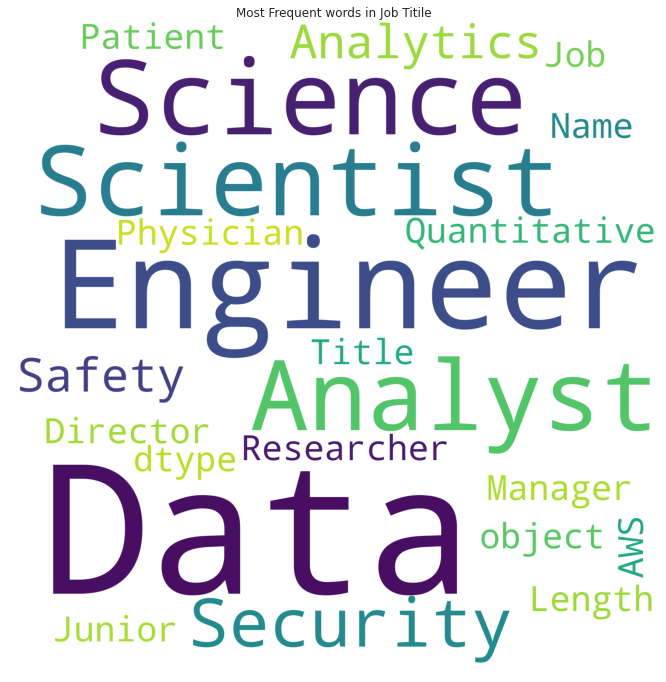

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                      height=2000,
                      width=2000
                     ).generate(str(trimed_df["Job Title"]))
plt.rcParams['figure.figsize'] = (12,12)
plt.axis("off")
plt.imshow(wordcloud)
plt.title("Most Frequent words in Job Titile")
plt.show()